<img src="../images/AzPTravel_PPM.png">

# Audit Report

## This script reads the output of the of the final data files and compares them to inputs. 

#### Euro Check
- Compare the deltas on teh Localcurr to the source and raise errors if they do not match

#### Prior over Period Check
- Quickly compare period over period and YoY final data files for major KPI's and row counts. 



### User Variables
- These are overwritten if inherited from run_control.ipynb.
- Feel Free to reset them for a manual run if you like
- Do not save without percode = "-f"

In [1]:
commit_message = "Development and testing."
# Give a brief reason for the run.

run_control = 1
#run_type = 0 - Lite run with no reporting, not recommended.
#run_type = 1 - Lite run with normal reporting, default setting.
#run_type = 2 - Heavy run with full reporting, available for audits and troubleshooting.
#run_type = 5 - A default setting. Indicates the script is being run by an outside process without an inherited value

percode = "2021.Q1"
# Data Collection Code, this controls file paths and output names
# "-f" is the value indicating a bad inheritance from run with arg

s_format = "p"
# denotes the source data format x == Excel; j == json, p == parquet

#----------
# do not edit - this either inherits the full instance timestamp from the papermill book or captures the run time of this script.
from datetime import datetime  # datetime options
inst_datetime = datetime.now().strftime("%m%d%Y%H%M%S")

In [2]:
# Parameters
run_control = 1
percode = "2021.Q1"
commit_message = "Live run, added AT, bad file name, rerun."
inst_datetime = "06022021112108"


#### Notebook display options

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#### import packages

In [4]:
#### Packages used

import os # System commands
import sys # System commands

import warnings # custom warnigns options

import glob # Directory operations
import getpass # Work with parquet
import json # Work with json

import matplotlib.pyplot as plt #Plots and Graphs
import seaborn as sns #Plots and Graphs
import numpy as np # Series and math
import pandas as pd #DataFrame and math

#excel operations
import re
import nicexcel as nl # Excel operations
import xlsxwriter # Excel operations
import openpyxl # Excel operations

#Not sure, test if needed
import timeit



#### Default Variables, these govern logic, do not edit.

In [5]:
default_dc = "20XX.QX"
default_rc = 0 #extra lite mode
dummy_perc = "33Q3" # bad inheritance

#### Script determining run context ie, manual, run_control.ipynb, or other.

In [6]:
if run_control == 5:
    run_control = default_rc 
else:
    run_control = run_control

try:
    if sys.argv[1] == "-f":
        percode = percode
    else:
        percode = sys.argv[1]

except IndexError:
    percode = default_dc
except NameError:
    percode = default_dc


if percode == "2021.Q1":
    
     prev_percode = "2020.Q4"
     prev_yearcode = "2020.Q1"

elif percode == "2020.Q4":
    
     prev_percode = "2020.Q3"
     prev_yearcode = "2019.Q4"

elif percode == "2020.Q3":
    
     prev_percode = "2020.Q1"
     prev_yearcode = "none"    

elif percode == "2020.Q1":
    
     prev_percode = "2019.Q4"
     prev_yearcode = "none"   

#### style settings

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.float_format', lambda x: '%.5f' % x)


## Begin Input Read
- Make paths used in script
- all paths should be modular and easily replaced ahead of operations.

In [8]:
#root directory
rt_path = f'\\\\hecate\\Insurance_US\\Product Development\\Product Management\\Global PPM\\Reporting\Data Collection'

# Euro file dir
euro_conv_source_path =current_path = os.path.join(rt_path ,percode,'External Resources')

# Source file dirs
current_path = os.path.join(rt_path ,"Production" , percode)
previous_period_path = os.path.join(rt_path ,"Production" , prev_percode)
previous_year_path = os.path.join(rt_path ,"Production" , prev_yearcode )




#### Make sources used in script
- all sources should be modular and easily replaced ahead of operations.

In [9]:
if "Q1" in percode:

    EURRATES = str.replace(f"EURRATES {percode}.xlsx","Q1","03.31")

elif  "Q2" in percode:

    EURRATES = str.replace(f"EURRATES {percode}.xlsx","Q2","06.30")

elif  "Q3" in percode:

    EURRATES = str.replace(f"EURRATES {percode}.xlsx","Q2","09.30")
    
elif  "Q4" in percode:

    EURRATES = str.replace(f"EURRATES {percode}.xlsx","Q2","12.31")
    
eurrates = os.path.join( euro_conv_source_path,   EURRATES)



current_lc_file = os.path.join(current_path  ,f'{percode}.localcur.csv')
current_eur_file  = os.path.join(current_path  ,f'{percode}.euroconv.csv')

previous_period_lc_file = os.path.join(previous_period_path ,f'{ prev_percode}.localcur.csv')
previous_period_eur_file  = os.path.join(previous_period_path ,f'{ prev_percode}.euroconv.csv')

previous_year_lc_file = os.path.join(previous_year_path  ,f'{ prev_yearcode}.localcur.csv')
previous_year_eur_file  = os.path.join(previous_year_path ,f'{ prev_yearcode}.euroconv.csv')


#### import data

In [10]:
eurrates_df = pd.read_excel(eurrates,sheet_name = "Output")


current_lc_df = pd.read_csv(current_lc_file , engine='python') 
current_eur_df = pd.read_csv(current_eur_file , engine='python') 


previous_period_lc_df = pd.read_csv(previous_period_lc_file, engine='python')
previous_period_eur_df = pd.read_csv(previous_period_eur_file , engine='python')


previous_year_lc_df = pd.read_csv(previous_year_lc_file, engine='python') 
previous_year_eur_df = pd.read_csv(previous_year_eur_file , engine='python')



## Begin Audits

#### Euro Conversion Check.
- Each major KPI evaluated bu Country by Currency in the source files and the official Allianz Connect reference report.

In [11]:
attributes = ['country', 'currency']

alt_attributes = ['Country', 'Currency']

comparison_fields = [
 'written_revenues_net_of_taxes',
 'written_revenues',
 'earned_revenues_net_of_taxes',
 'earned_revenues',
 'total_compensation',
  'actual_incurred_losses_(paid_+_ocr_+_ibnr)',
 'total_expenses',
 'profit_or_loss',
]


alt_comparison_fields = [
'Written Revenues net of Taxes',
 'Written Revenues',
 'Earned Revenues net of Taxes',
 'Earned Revenues',
 'Total Compensation',
 'Actual Incurred Losses (Paid + OCR + IBNR)',
 'Total Expenses',
 'Profit or Loss',
]

view_cols = [] 

for a in attributes: view_cols.append(a)
for c in comparison_fields: view_cols.append(c)

    
    
alt_view_cols = [] 

for a in alt_attributes: alt_view_cols.append(a)
for c in alt_comparison_fields: alt_view_cols.append(c)
    

current_eur_view =  current_eur_df[view_cols].groupby(attributes).sum()

try:
    current_lc_view =  current_lc_df[view_cols].groupby(attributes).sum()

except KeyError:
    current_lc_view =  current_lc_df[alt_view_cols].groupby(alt_attributes).sum()  
    

previous_period_eur_view =  previous_period_eur_df[view_cols].groupby(attributes).sum()    
previous_year_eur_view =  previous_year_eur_df[view_cols].groupby(attributes).sum()    




In [12]:

calculated_rates = current_lc_view.div(current_eur_view).reset_index()

calculated_rates = calculated_rates.melt(id_vars=attributes).reset_index(drop = True)

calculated_rates = calculated_rates[["country","currency", "value"]]

calculated_rates['value'] = calculated_rates['value'].round(5)

calculated_rates = calculated_rates.drop_duplicates()[calculated_rates['value'].notna()]
calculated_rates 

C:\Users\gharmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,country,currency,value
0,AT,EUR,1.00000
1,AU,AUD,1.54310
2,BG,EUR,1.00000
3,CA,CAD,1.47720
4,CH,CHF,1.10615
5,CZ,EUR,1.00000
6,ES,EUR,1.00000
7,GR,EUR,1.00000
8,HU,EUR,1.00000
9,IT,EUR,1.00000


In [13]:
test = 1

if calculated_rates.groupby( attributes).count()['value'].max() != 1: 
    
    test = 0

else:
    
    pass
        
        
1/test # if this is an error you have bad currency conversions and possibly a bad join with extra rows

#todo build a proper error class

1.0

In [14]:

test = 1

if len(current_eur_df[attributes].drop_duplicates()) != len(calculated_rates): 
    
    test = 0

else:
    pass

1/test # if this is an error you do not have the same number of country and curreny combos in all views. Major problem!

#todo build a proper error class



1.0

In [15]:
conversion_comparison =  calculated_rates.merge( eurrates_df,  how='left',  left_on='currency', right_on='CurrCode' )

conversion_comparison




,country,currency,value,CurrCode,Country,EUR_2_LC,LC_2_EUR
0,AT,EUR,1.00000,EUR,Euro,1.00000,1.00000
1,AU,AUD,1.54310,AUD,Australia,1.54310,0.64805
2,BG,EUR,1.00000,EUR,Euro,1.00000,1.00000
3,CA,CAD,1.47720,CAD,Canada,1.47720,0.67696
4,CH,CHF,1.10615,CHF,Switzerland,1.10615,0.90404
5,CZ,EUR,1.00000,EUR,Euro,1.00000,1.00000
6,ES,EUR,1.00000,EUR,Euro,1.00000,1.00000
7,GR,EUR,1.00000,EUR,Euro,1.00000,1.00000
8,HU,EUR,1.00000,EUR,Euro,1.00000,1.00000
9,IT,EUR,1.00000,EUR,Euro,1.00000,1.00000


In [16]:
euro_df = conversion_comparison

%store euro_df


Stored 'euro_df' (DataFrame)


In [17]:

test = 1

if (   conversion_comparison['value']   - conversion_comparison['EUR_2_LC']).sum() != 0: 
    
    test = 0

else:
    pass

1/test # if this is an error you do not match the source currency document. Major problem!

#todo build a proper error class


1.0

#### Data views for evaluation
- Create several views in order to populate graphs

In [18]:
current_eur_view['Period'] = percode
previous_period_eur_view['Period']  =    prev_percode 
previous_year_eur_view['Period']    =  prev_yearcode 



In [19]:
rowcounts = pd.DataFrame()

rowcounts_current = current_eur_df[["country","written_revenues_net_of_taxes"]].groupby("country").count() 

rowcounts_current["Period"] = percode


rowcounts_prev_per = previous_period_eur_df[["country","written_revenues_net_of_taxes"]].groupby("country").count() 

rowcounts_prev_per["Period"] = prev_percode 


rowcounts_py = previous_year_eur_df[["country","written_revenues_net_of_taxes"]].groupby("country").count() 

rowcounts_py["Period"] = prev_yearcode 


rowcounts = rowcounts.append(rowcounts_current).append(rowcounts_prev_per).append(rowcounts_py)
rowcounts = rowcounts.rename( { 'written_revenues_net_of_taxes' :'Rowcounts' }, axis='columns')

rowcounts = rowcounts.reset_index()




In [20]:
combo_views = current_eur_view.append(previous_period_eur_view).append(previous_year_eur_view)

combo_views

,,written_revenues_net_of_taxes,written_revenues,earned_revenues_net_of_taxes,earned_revenues,total_compensation,actual_incurred_losses_(paid_+_ocr_+_ibnr),total_expenses,profit_or_loss,Period
country,currency,,,,,,,,,
AT,EUR,1263968.01000,1395973.91000,1263968.01000,1395973.91000,184705.16000,-198293.93474,379665.68759,897891.09715,2021.Q1
AU,AUD,91686.79036,0.00000,9332572.90584,0.00000,216127.95390,1811872.66040,4832421.23620,2472151.05534,2021.Q1
BG,EUR,250935.21867,256065.50397,250935.21867,256065.50397,68238.36454,-457009.40088,9107.43570,630598.81931,2021.Q1
CA,CAD,6774281.88465,6804054.73869,7906948.34916,0.00000,2233722.50171,4417080.28482,1771533.24975,-515387.68713,2021.Q1
CH,CHF,27181112.76952,0.00000,31246379.71907,0.00000,7519635.50344,5470941.93045,8826348.84822,9429453.43697,2021.Q1
...,...,...,...,...,...,...,...,...,...,...
PL,EUR,7338567.83355,7338567.83355,5589756.43733,5589756.43733,2641837.05568,2957760.75136,1164651.95704,-1174493.32674,2020.Q1
PT,EUR,178994.56000,172085.95000,175055.42872,164756.71451,10856.48738,45381.81000,54961.74333,63855.38801,2020.Q1
SE,EUR,3212611.00000,0.00000,3073854.00000,0.00000,1805938.00000,606724.00000,234227.67480,426964.32520,2020.Q1


In [21]:
combo_views = combo_views.reset_index()

melt_cv = combo_views.melt(['country','Period','currency'], ignore_index = True)

melt_cv['value'] = melt_cv['value'].fillna(0)


In [22]:
check_set0 = melt_cv[melt_cv["Period"] == percode].groupby( ["country"]).sum()

include = check_set0.index.values

include = list(include)

melt_cv = melt_cv[(melt_cv["country"].isin(include)) & (~melt_cv["variable"].isin(["index","written_revenues","earned_revenues"]) )]




#Rowcount visual
- see how many rows were submitted by each BU in this data submission vs the previous submission and the YoY submission.

Text(0.5, 1149.2000000000003, 'AT')

Text(10.175000000000004, 0.5, 'Rows Submitted')

Text(0.5, 1149.2000000000003, 'AU')

Text(295.47499999999997, 0.5, 'Rows Submitted')

Text(0.5, 1149.2000000000003, 'BG')

Text(587.0250000000001, 0.5, 'Rows Submitted')

Text(0.5, 1149.2000000000003, 'CA')

Text(859.7, 0.5, 'Rows Submitted')

Text(0.5, 1006.4000000000001, 'CH')

Text(3.8000000000000043, 0.5, 'Rows Submitted')

Text(0.5, 1006.4000000000001, 'CZ')

Text(307.97499999999997, 0.5, 'Rows Submitted')

Text(0.5, 1006.4000000000001, 'ES')

Text(587.0250000000001, 0.5, 'Rows Submitted')

Text(0.5, 1006.4000000000001, 'GR')

Text(872.2, 0.5, 'Rows Submitted')

Text(0.5, 863.6000000000001, 'HU')

Text(10.175000000000004, 0.5, 'Rows Submitted')

Text(0.5, 863.6000000000001, 'IT')

Text(295.47499999999997, 0.5, 'Rows Submitted')

Text(0.5, 863.6000000000001, 'NL')

Text(580.6500000000001, 0.5, 'Rows Submitted')

Text(0.5, 863.6000000000001, 'PL')

Text(872.325, 0.5, 'Rows Submitted')

Text(0.5, 720.8000000000001, 'PT')

Text(16.425000000000004, 0.5, 'Rows Submitted')

Text(0.5, 720.8000000000001, 'RO')

Text(295.47499999999997, 0.5, 'Rows Submitted')

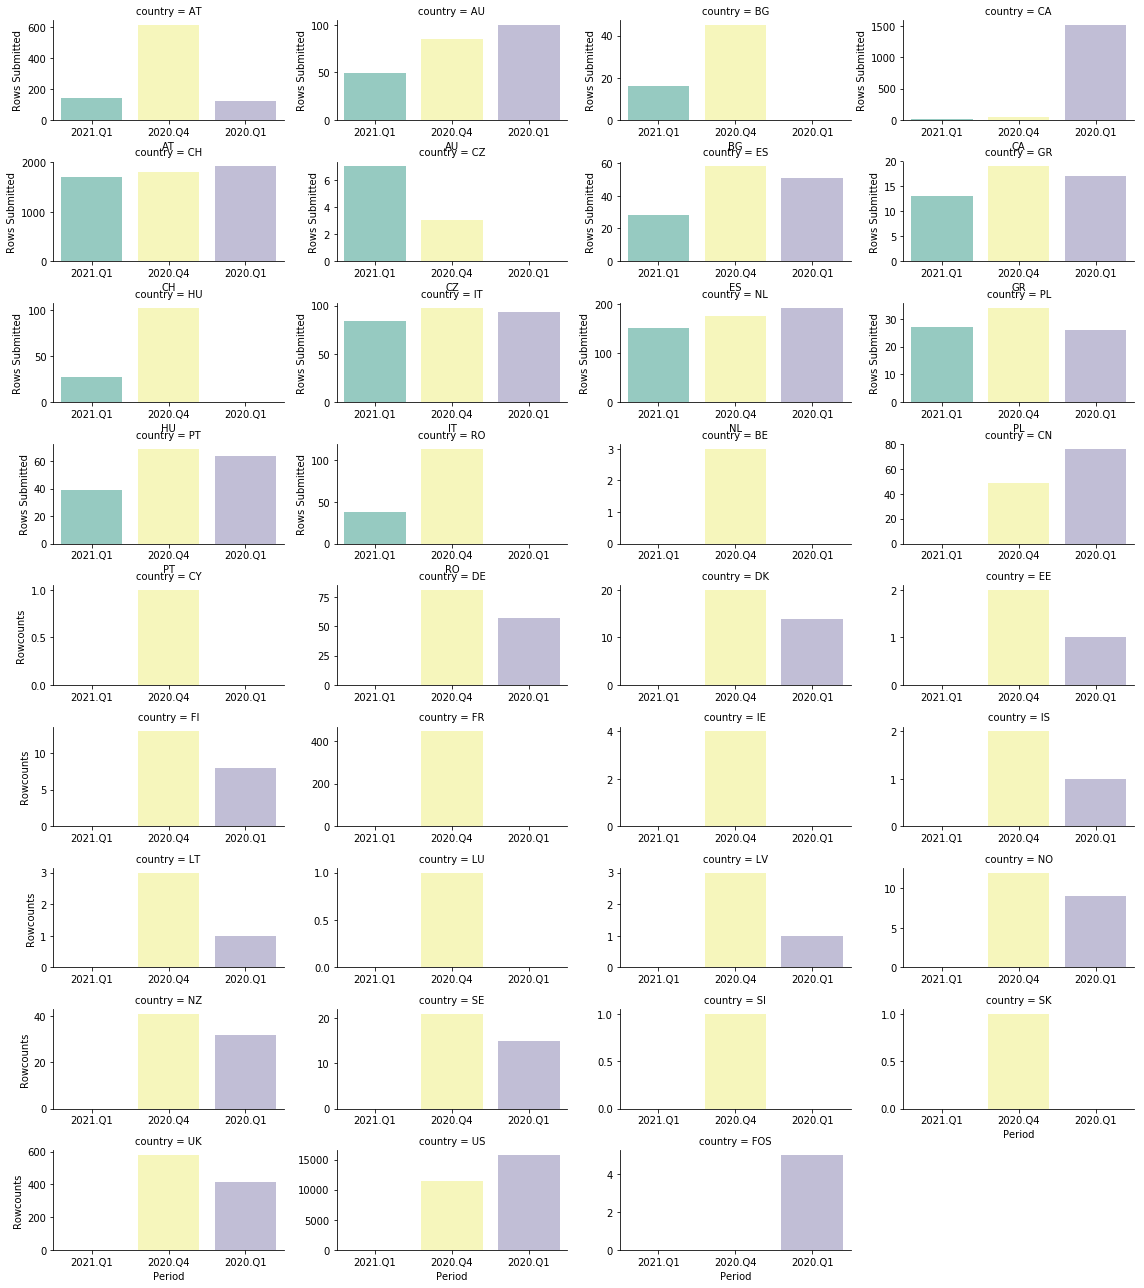

In [23]:
order = rowcounts.Period.unique()

included = (include * 6)
included.sort()

g = sns.FacetGrid(rowcounts, col="country",  hue="Period", palette="Set3",col_wrap = 4, height=2, aspect=2, margin_titles=True, legend_out=False, sharex=False, sharey=False)
g.map(sns.barplot, "Period", "Rowcounts", order=order, ci=None, label = True)
axes = g.axes.flatten()
for ax, b  in zip(axes, include):
    ax.set_xlabel(b)
    ax.set_ylabel("Rows Submitted")


g.savefig('rows.png', dpi=125)

#KPI visual
- Displays in KPI totals in Euros for this data submission vs the previous submission and the YoY submission.

Text(0.5, 1868.771428571429, 'AT')

Text(-14.824999999999982, 0.5, 'Euro')

Text(0.5, 1868.771428571429, 'AT')

Text(271.37500000000006, 0.5, 'Euro')

Text(0.5, 1868.771428571429, 'AT')

Text(557.45, 0.5, 'Euro')

Text(0.5, 1868.771428571429, 'AT')

Text(843.7750000000001, 0.5, 'Euro')

Text(0.5, 1868.771428571429, 'AT')

Text(1129.8500000000001, 0.5, 'Euro')

Text(0.5, 1868.771428571429, 'AT')

Text(1414.0500000000002, 0.5, 'Euro')

Text(0.5, 1725.5428571428577, 'AU')

Text(6.8000000000000185, 0.5, 'Euro')

Text(0.5, 1725.5428571428577, 'AU')

Text(293.00000000000006, 0.5, 'Euro')

Text(0.5, 1725.5428571428577, 'AU')

Text(585.45, 0.5, 'Euro')

Text(0.5, 1725.5428571428577, 'AU')

Text(881.2750000000001, 0.5, 'Euro')

Text(0.5, 1725.5428571428577, 'AU')

Text(1167.4750000000001, 0.5, 'Euro')

Text(0.5, 1725.5428571428577, 'AU')

Text(1429.4250000000002, 0.5, 'Euro')

Text(0.5, 1582.314285714286, 'BG')

Text(-8.574999999999982, 0.5, 'Euro')

Text(0.5, 1582.314285714286, 'BG')

Text(277.62500000000006, 0.5, 'Euro')

Text(0.5, 1582.314285714286, 'BG')

Text(570.075, 0.5, 'Euro')

Text(0.5, 1582.314285714286, 'BG')

Text(841.5250000000001, 0.5, 'Euro')

Text(0.5, 1582.314285714286, 'BG')

Text(1136.2250000000001, 0.5, 'Euro')

Text(0.5, 1582.314285714286, 'BG')

Text(1414.0500000000002, 0.5, 'Euro')

Text(0.5, 1439.0857142857146, 'CA')

Text(13.175000000000018, 0.5, 'Euro')

Text(0.5, 1439.0857142857146, 'CA')

Text(299.37500000000006, 0.5, 'Euro')

Text(0.5, 1439.0857142857146, 'CA')

Text(595.075, 0.5, 'Euro')

Text(0.5, 1439.0857142857146, 'CA')

Text(881.2750000000001, 0.5, 'Euro')

Text(0.5, 1439.0857142857146, 'CA')

Text(1167.4750000000001, 0.5, 'Euro')

Text(0.5, 1439.0857142857146, 'CA')

Text(1407.6750000000002, 0.5, 'Euro')

Text(0.5, 1295.8571428571431, 'CH')

Text(22.67500000000002, 0.5, 'Euro')

Text(0.5, 1295.8571428571431, 'CH')

Text(308.87500000000006, 0.5, 'Euro')

Text(0.5, 1295.8571428571431, 'CH')

Text(585.575, 0.5, 'Euro')

Text(0.5, 1295.8571428571431, 'CH')

Text(871.6500000000001, 0.5, 'Euro')

Text(0.5, 1295.8571428571431, 'CH')

Text(1151.6000000000001, 0.5, 'Euro')

Text(0.5, 1295.8571428571431, 'CH')

Text(1437.8000000000002, 0.5, 'Euro')

Text(0.5, 1152.6285714285716, 'CZ')

Text(-8.574999999999982, 0.5, 'Euro')

Text(0.5, 1152.6285714285716, 'CZ')

Text(277.62500000000006, 0.5, 'Euro')

Text(0.5, 1152.6285714285716, 'CZ')

Text(563.7, 0.5, 'Euro')

Text(0.5, 1152.6285714285716, 'CZ')

Text(850.0250000000001, 0.5, 'Euro')

Text(0.5, 1152.6285714285716, 'CZ')

Text(1142.4750000000001, 0.5, 'Euro')

Text(0.5, 1152.6285714285716, 'CZ')

Text(1414.0500000000002, 0.5, 'Euro')

Text(0.5, 1009.4000000000003, 'ES')

Text(-14.824999999999982, 0.5, 'Euro')

Text(0.5, 1009.4000000000003, 'ES')

Text(271.37500000000006, 0.5, 'Euro')

Text(0.5, 1009.4000000000003, 'ES')

Text(557.45, 0.5, 'Euro')

Text(0.5, 1009.4000000000003, 'ES')

Text(850.0250000000001, 0.5, 'Euro')

Text(0.5, 1009.4000000000003, 'ES')

Text(1129.8500000000001, 0.5, 'Euro')

Text(0.5, 1009.4000000000003, 'ES')

Text(1414.0500000000002, 0.5, 'Euro')

Text(0.5, 866.1714285714289, 'GR')

Text(-14.949999999999982, 0.5, 'Euro')

Text(0.5, 866.1714285714289, 'GR')

Text(271.25000000000006, 0.5, 'Euro')

Text(0.5, 866.1714285714289, 'GR')

Text(563.825, 0.5, 'Euro')

Text(0.5, 866.1714285714289, 'GR')

Text(850.0250000000001, 0.5, 'Euro')

Text(0.5, 866.1714285714289, 'GR')

Text(1136.2250000000001, 0.5, 'Euro')

Text(0.5, 866.1714285714289, 'GR')

Text(1422.4250000000002, 0.5, 'Euro')

Text(0.5, 722.9428571428574, 'HU')

Text(-8.574999999999982, 0.5, 'Euro')

Text(0.5, 722.9428571428574, 'HU')

Text(277.62500000000006, 0.5, 'Euro')

Text(0.5, 722.9428571428574, 'HU')

Text(563.7, 0.5, 'Euro')

Text(0.5, 722.9428571428574, 'HU')

Text(850.0250000000001, 0.5, 'Euro')

Text(0.5, 722.9428571428574, 'HU')

Text(1136.2250000000001, 0.5, 'Euro')

Text(0.5, 722.9428571428574, 'HU')

Text(1414.0500000000002, 0.5, 'Euro')

Text(0.5, 579.7142857142859, 'IT')

Text(22.67500000000002, 0.5, 'Euro')

Text(0.5, 579.7142857142859, 'IT')

Text(308.87500000000006, 0.5, 'Euro')

Text(0.5, 579.7142857142859, 'IT')

Text(585.575, 0.5, 'Euro')

Text(0.5, 579.7142857142859, 'IT')

Text(871.6500000000001, 0.5, 'Euro')

Text(0.5, 579.7142857142859, 'IT')

Text(1157.8500000000001, 0.5, 'Euro')

Text(0.5, 579.7142857142859, 'IT')

Text(1435.8000000000002, 0.5, 'Euro')

Text(0.5, 436.4857142857144, 'NL')

Text(22.67500000000002, 0.5, 'Euro')

Text(0.5, 436.4857142857144, 'NL')

Text(308.87500000000006, 0.5, 'Euro')

Text(0.5, 436.4857142857144, 'NL')

Text(585.45, 0.5, 'Euro')

Text(0.5, 436.4857142857144, 'NL')

Text(871.6500000000001, 0.5, 'Euro')

Text(0.5, 436.4857142857144, 'NL')

Text(1157.9750000000001, 0.5, 'Euro')

Text(0.5, 436.4857142857144, 'NL')

Text(1416.1750000000002, 0.5, 'Euro')

Text(0.5, 293.25714285714287, 'PL')

Text(13.050000000000018, 0.5, 'Euro')

Text(0.5, 293.25714285714287, 'PL')

Text(299.25000000000006, 0.5, 'Euro')

Text(0.5, 293.25714285714287, 'PL')

Text(557.575, 0.5, 'Euro')

Text(0.5, 293.25714285714287, 'PL')

Text(843.7750000000001, 0.5, 'Euro')

Text(0.5, 293.25714285714287, 'PL')

Text(1129.9750000000001, 0.5, 'Euro')

Text(0.5, 293.25714285714287, 'PL')

Text(1407.8000000000002, 0.5, 'Euro')

Text(0.5, 150.0285714285714, 'PT')

Text(-8.574999999999982, 0.5, 'Euro')

Text(0.5, 150.0285714285714, 'PT')

Text(277.62500000000006, 0.5, 'Euro')

Text(0.5, 150.0285714285714, 'PT')

Text(570.075, 0.5, 'Euro')

Text(0.5, 150.0285714285714, 'PT')

Text(849.9000000000001, 0.5, 'Euro')

Text(0.5, 150.0285714285714, 'PT')

Text(1136.1000000000001, 0.5, 'Euro')

Text(0.5, 150.0285714285714, 'PT')

Text(1422.4250000000002, 0.5, 'Euro')

Text(0.5, 6.799999999999901, 'RO')

Text(-14.824999999999982, 0.5, 'Euro')

Text(0.5, 6.799999999999901, 'RO')

Text(271.37500000000006, 0.5, 'Euro')

Text(0.5, 6.799999999999901, 'RO')

Text(563.825, 0.5, 'Euro')

Text(0.5, 6.799999999999901, 'RO')

Text(843.7750000000001, 0.5, 'Euro')

Text(0.5, 6.799999999999901, 'RO')

Text(1129.9750000000001, 0.5, 'Euro')

Text(0.5, 6.799999999999901, 'RO')

Text(1414.0500000000002, 0.5, 'Euro')

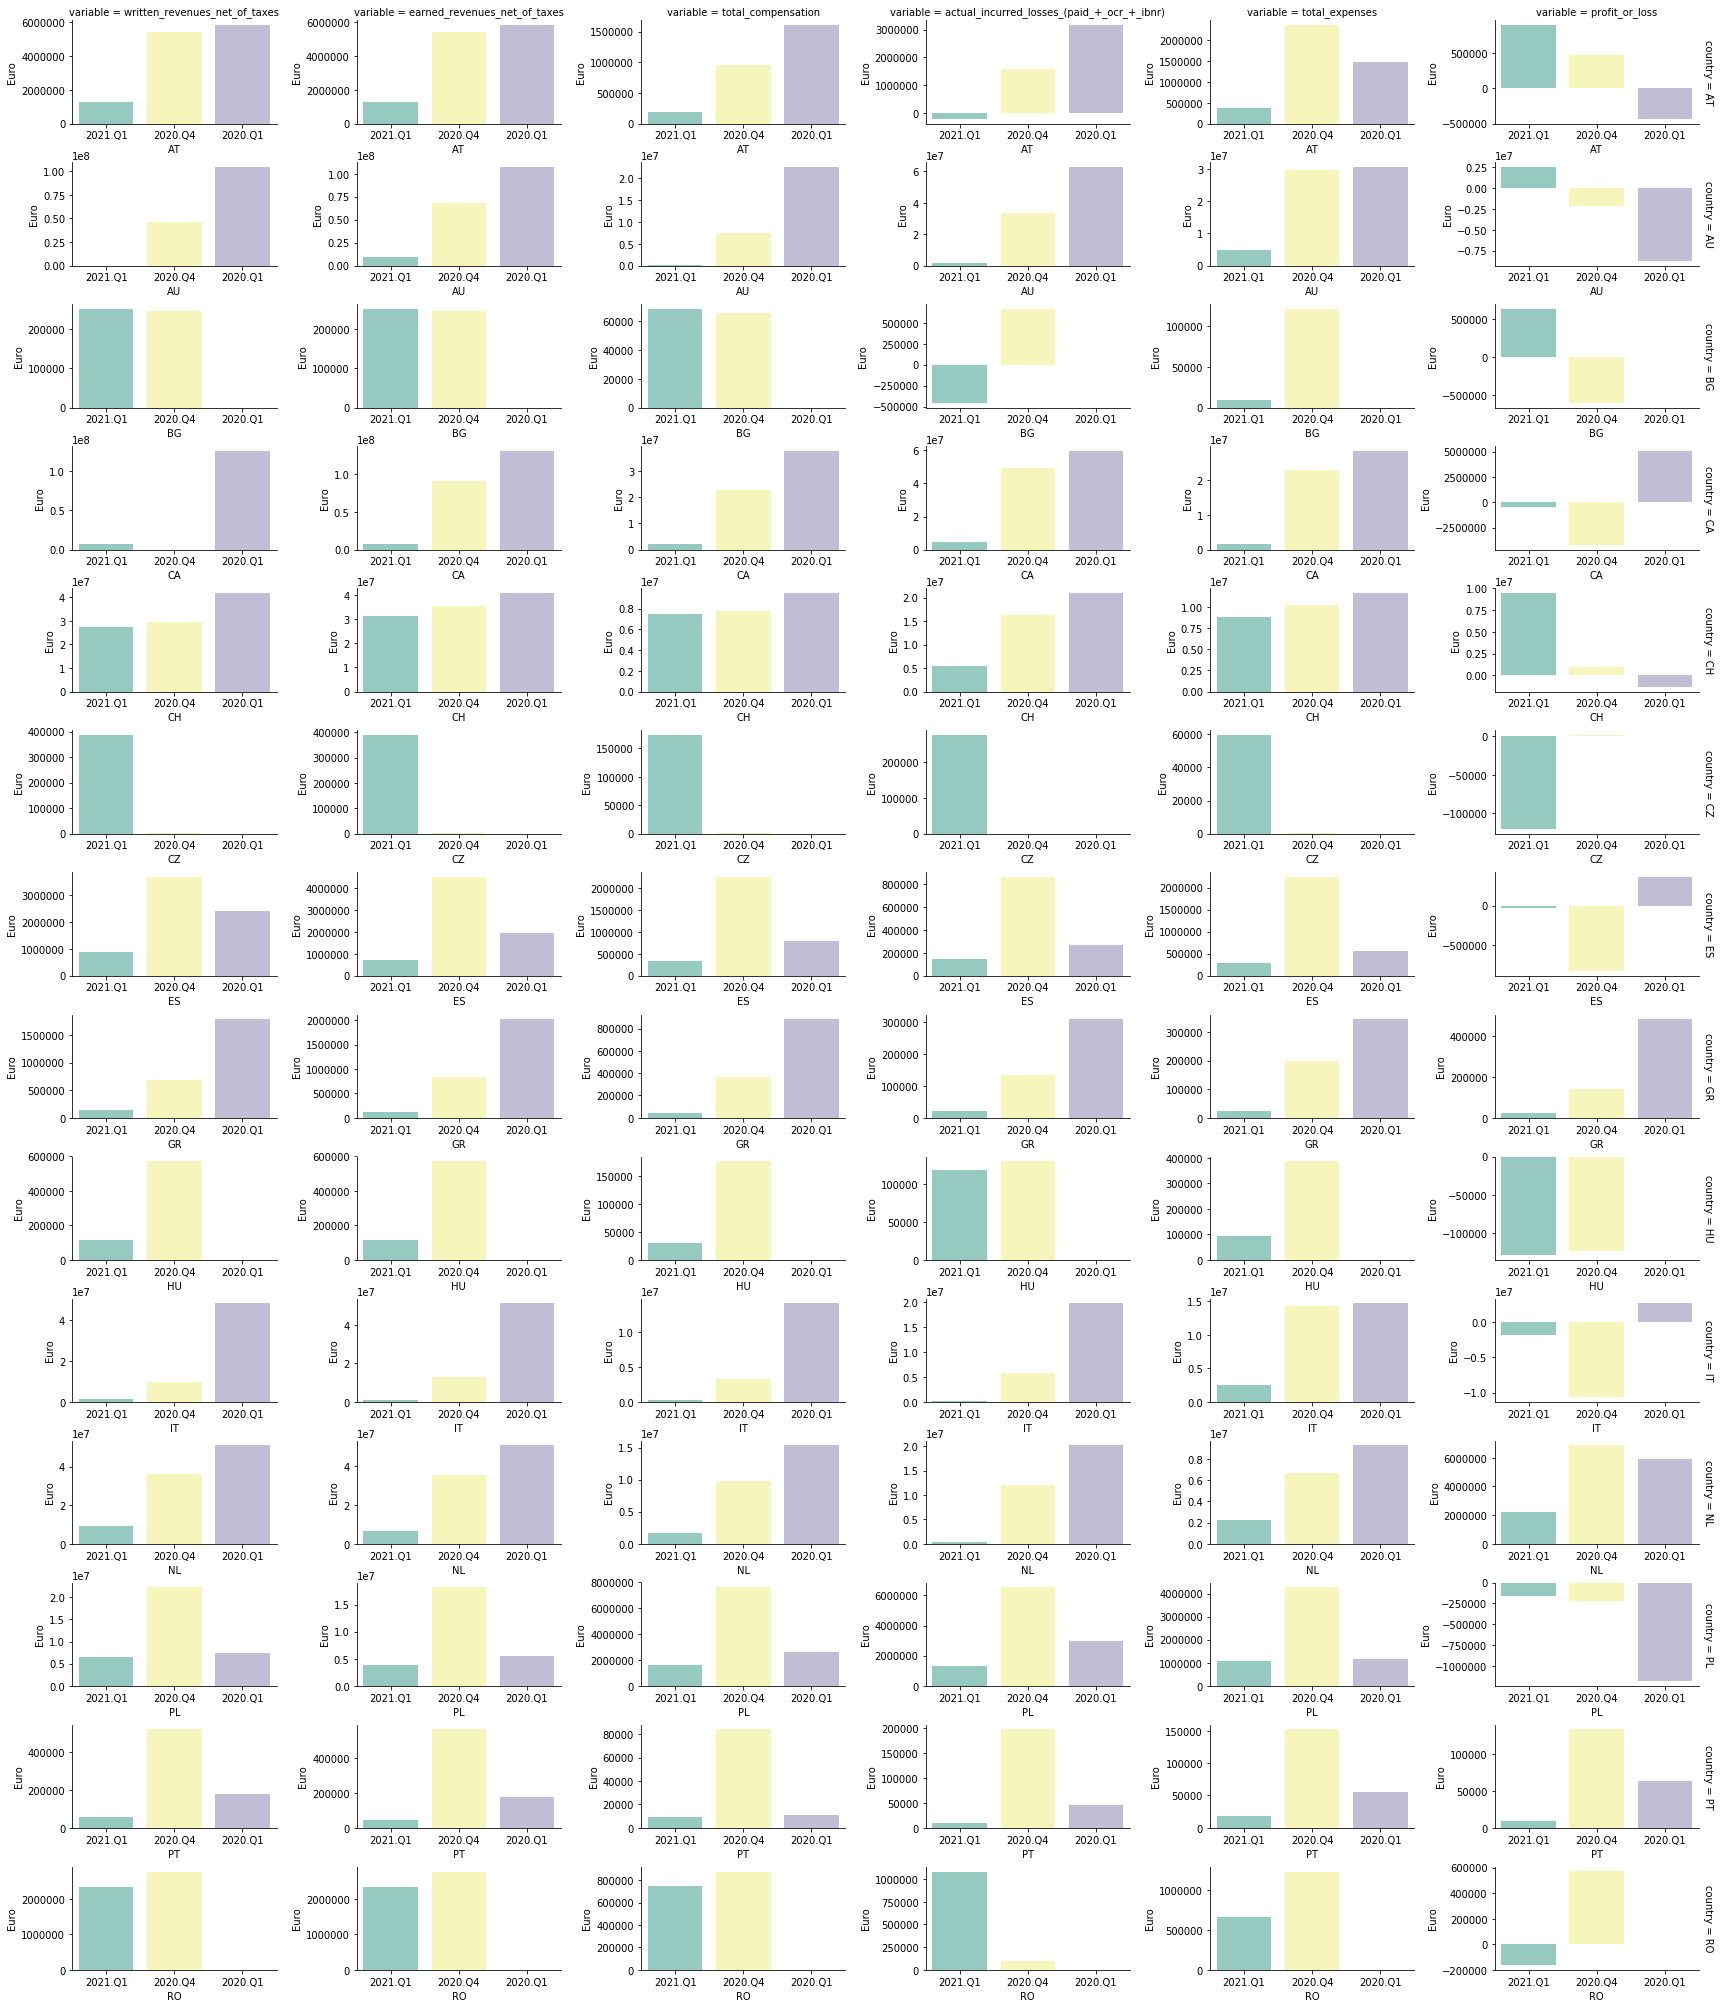

In [24]:
included = (include * 6)
included.sort()

g = sns.FacetGrid(melt_cv, row="country", col="variable",  hue="Period", palette="Set3", height=2, aspect=2, margin_titles=True, legend_out=False, sharex=False, sharey=False)
g.map(sns.barplot, "Period", "value", order=order, ci=None, label = True)
axes = g.axes.flatten()
for ax, b  in zip(axes, included):
    ax.set_xlabel(b)
    ax.set_ylabel("Euro")
    
g.savefig('KPIs.png', dpi=125)

Text(0.5, 1867.865178571429, 'AT')

Text(-14.824999999999996, 0.5, 'Euro')

Text(0.5, 1867.865178571429, 'AT')

Text(269.57500000000005, 0.5, 'Euro')

Text(0.5, 1867.865178571429, 'AT')

Text(553.975, 0.5, 'Euro')

Text(0.5, 1724.6366071428577, 'AT')

Text(13.175000000000004, 0.5, 'Euro')

Text(0.5, 1724.6366071428577, 'AT')

Text(307.07500000000005, 0.5, 'Euro')

Text(0.5, 1724.6366071428577, 'AT')

Text(581.975, 0.5, 'Euro')

Text(0.5, 1581.408035714286, 'AU')

Text(-17.074999999999996, 0.5, 'Euro')

Text(0.5, 1581.408035714286, 'AU')

Text(267.45000000000005, 0.5, 'Euro')

Text(0.5, 1582.314285714286, 'AU')

Text(581.975, 0.5, 'Euro')

Text(0.5, 1438.1794642857146, 'AU')

Text(13.175000000000004, 0.5, 'Euro')

Text(0.5, 1438.1794642857146, 'AU')

Text(291.20000000000005, 0.5, 'Euro')

Text(0.5, 1438.1794642857146, 'AU')

Text(581.975, 0.5, 'Euro')

Text(0.5, 1294.9508928571431, 'BG')

Text(22.675000000000004, 0.5, 'Euro')

Text(0.5, 1294.9508928571431, 'BG')

Text(307.07500000000005, 0.5, 'Euro')

Text(0.5, 1294.9508928571431, 'BG')

Text(591.475, 0.5, 'Euro')

Text(0.5, 1151.7223214285716, 'BG')

Text(-8.574999999999996, 0.5, 'Euro')

Text(0.5, 1151.7223214285716, 'BG')

Text(288.32500000000005, 0.5, 'Euro')

Text(0.5, 1152.6285714285716, 'BG')

Text(581.975, 0.5, 'Euro')

Text(0.5, 1008.4937500000003, 'CA')

Text(-8.699999999999996, 0.5, 'Euro')

Text(0.5, 1008.4937500000003, 'CA')

Text(269.57500000000005, 0.5, 'Euro')

Text(0.5, 1008.4937500000003, 'CA')

Text(553.975, 0.5, 'Euro')

Text(0.5, 865.2651785714289, 'CA')

Text(-8.574999999999996, 0.5, 'Euro')

Text(0.5, 865.2651785714289, 'CA')

Text(275.82500000000005, 0.5, 'Euro')

Text(0.5, 865.2651785714289, 'CA')

Text(553.85, 0.5, 'Euro')

Text(0.5, 722.0366071428574, 'CH')

Text(-16.949999999999996, 0.5, 'Euro')

Text(0.5, 722.0366071428574, 'CH')

Text(275.82500000000005, 0.5, 'Euro')

Text(0.5, 722.9428571428574, 'CH')

Text(581.975, 0.5, 'Euro')

Text(0.5, 578.8080357142859, 'CH')

Text(-23.199999999999996, 0.5, 'Euro')

Text(0.5, 578.8080357142859, 'CH')

Text(298.70000000000005, 0.5, 'Euro')

Text(0.5, 578.8080357142859, 'CH')

Text(591.475, 0.5, 'Euro')

Text(0.5, 435.5794642857144, 'CZ')

Text(13.175000000000004, 0.5, 'Euro')

Text(0.5, 435.5794642857144, 'CZ')

Text(307.07500000000005, 0.5, 'Euro')

Text(0.5, 435.5794642857144, 'CZ')

Text(591.475, 0.5, 'Euro')

Text(0.5, 292.35089285714287, 'CZ')

Text(-14.824999999999996, 0.5, 'Euro')

Text(0.5, 292.35089285714287, 'CZ')

Text(297.45000000000005, 0.5, 'Euro')

Text(0.5, 292.35089285714287, 'CZ')

Text(553.975, 0.5, 'Euro')

Text(0.5, 149.1223214285714, 'ES')

Text(-2.3249999999999957, 0.5, 'Euro')

Text(0.5, 149.1223214285714, 'ES')

Text(275.82500000000005, 0.5, 'Euro')

Text(0.5, 149.1223214285714, 'ES')

Text(560.1, 0.5, 'Euro')

Text(0.5, 5.893749999999901, 'ES')

Text(-14.824999999999996, 0.5, 'Euro')

Text(0.5, 5.893749999999901, 'ES')

Text(269.57500000000005, 0.5, 'Euro')

Text(0.5, 6.799999999999901, 'ES')

Text(581.975, 0.5, 'Euro')

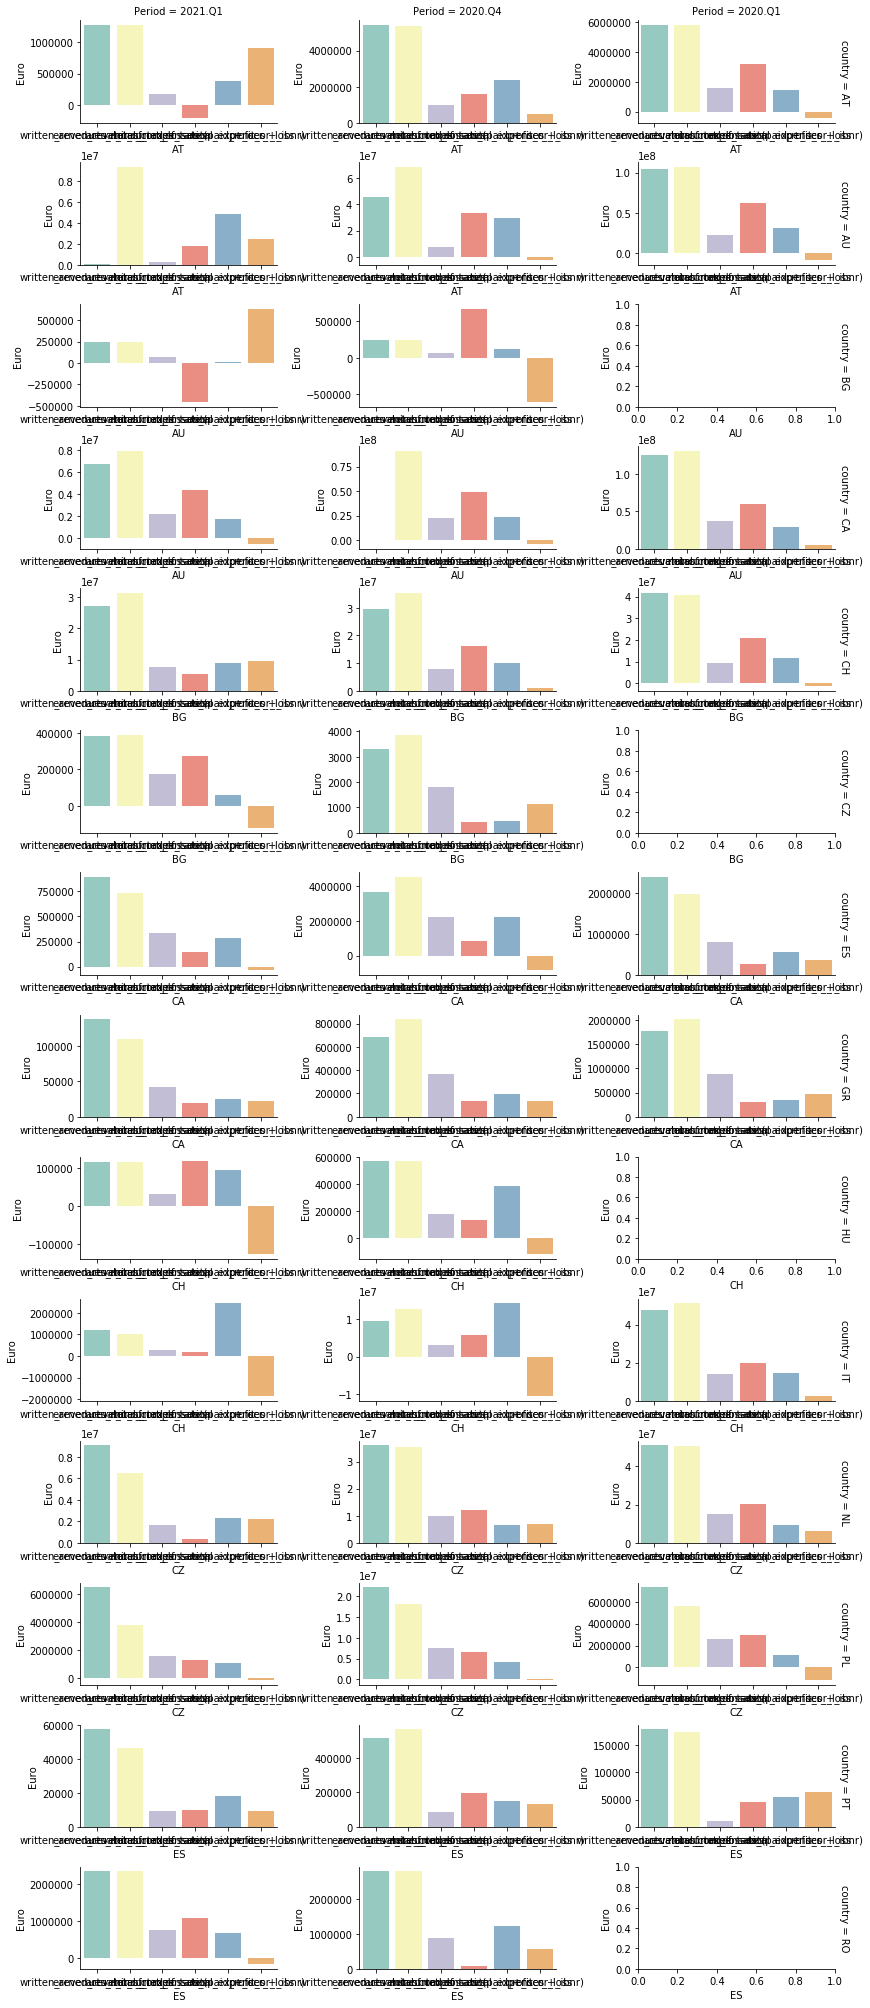

In [25]:
order = melt_cv.variable.unique()


included = (include * 6)
included.sort()

g = sns.FacetGrid(melt_cv, row="country", col= "Period" , hue= "variable",  palette="Set3", height=2, aspect=2, margin_titles=True, legend_out=False, sharex=False, sharey=False)
g.map(sns.barplot, "variable", "value", order=order, ci=None, label = True)
axes = g.axes.flatten()
for ax, b  in zip(axes, included):
    ax.set_xlabel(b)
    ax.set_ylabel("Euro")
    
g.savefig('KPIs_vw2.png', dpi=200)